# Lab06: Overfitting, Activations, Optimizers, and Regularization

In this lab we will:
- Visualize and understand overfitting on a simple dataset.
- Compare Sigmoid, ReLU, and GELU (intuitions, curves, derivatives).
- Implement SGD, Momentum, RMSprop, and Adam from scratch and visualize their behavior on a 2D quadratic.
- Implement and observe effects of L1/L2 regularization on parameter norms and generalization.
- Implement Dropout, BatchNorm, and LayerNorm using basic tensor ops.
- Build simple data augmentations using basic tensor operations (no torchvision transforms).

We avoid high-level helpers (`torch.optim`, `nn.Dropout`, `nn.BatchNorm`, etc.) to show how these work under the hood.


In [1]:
# Setup
import math, random, os, sys, time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

## Activation Functions: Sigmoid, ReLU, GELU
We plot each function and its derivative to build intuition about saturation and gradient flow.

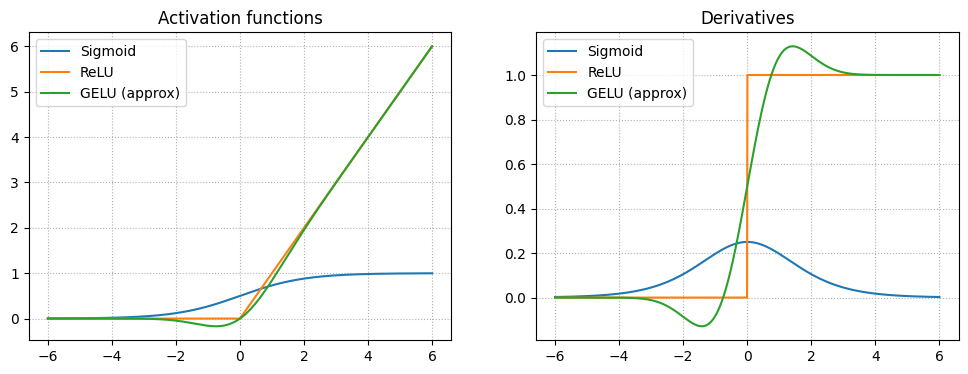

In [2]:
# Define activations using basic ops
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def relu(x):
    return torch.clamp(x, min=0.0)

# Approximate GELU (Hendrycks & Gimpel)
# gelu(x) ≈ 0.5 x [1 + tanh(
#   sqrt(2/pi) * (x + 0.044715 x^3) )] 
def gelu(x):
    c = math.sqrt(2.0 / math.pi)
    return 0.5 * x * (1.0 + torch.tanh(c * (x + 0.044715 * x**3)))

# Helper to compute derivative via autograd for elementwise functions
def elementwise_derivative(fn, xs):
    xs = xs.clone().detach().requires_grad_(True)
    ys = fn(xs)
    # sum to create scalar; autograd returns grad same shape as xs
    s = ys.sum()
    s.backward()
    return xs.grad

xs = torch.linspace(-6, 6, 1000)
acts = {
    'Sigmoid': sigmoid,
    'ReLU': relu,
    'GELU (approx)': gelu
}

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for name, fn in acts.items():
    ys = fn(xs)
    dys = elementwise_derivative(fn, xs)
    axs[0].plot(xs, ys, label=name)
    axs[1].plot(xs, dys, label=name)
axs[0].set_title('Activation functions')
axs[1].set_title('Derivatives')
for ax in axs:
    ax.grid(True, ls=':')
    ax.legend()
plt.show()


Notes:
- Sigmoid saturates for large |x|, causing tiny gradients.
- ReLU is piecewise linear, avoids saturation for x>0 but kills gradients for x<0.
- GELU is smooth like sigmoid but less saturating around 0, often trains well in deep nets.

## Optimizers From Scratch (1D + Rosenbrock)
We optimize simple 1D functions and then the 2D Rosenbrock to show why Momentum/Adam can outperform plain SGD.

1D function (convex): f(w) = 0.5 · a · w^2 + b · w + c (we use b=0, c=0).
1D non‑quadratic (wavy): f(w) = 0.5 · a · w^2 + α·sin(βw).
Rosenbrock 2D (non‑quadratic valley): f(x,y) = (1 − x)^2 + 100·(y − x^2)^2.

Plots below:
- The 1D function curve y=f(w) with step-by-step positions (w_t, f(w_t)).
- Objective value f(w) vs iteration (log scale), and w vs iteration.
- Rosenbrock: contour + trajectories and objective vs iteration (log).

What to look for: faster, smoother descent (f(w) drops quickly, fewer zig‑zags).
On Rosenbrock’s curved, narrow valley, Momentum/Adam typically converge faster and with less zig‑zag than plain SGD.

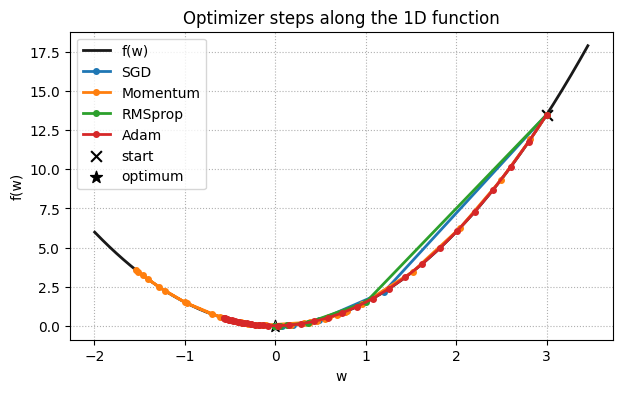

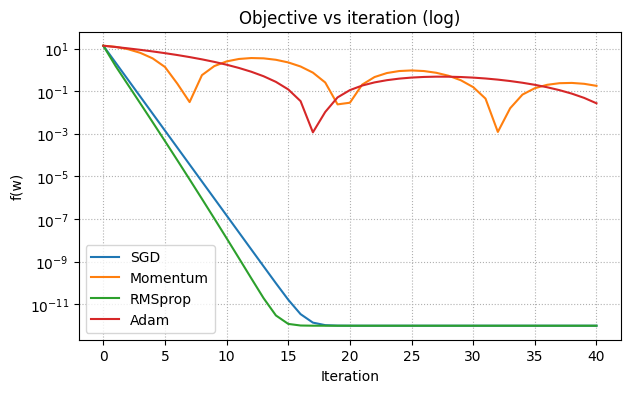

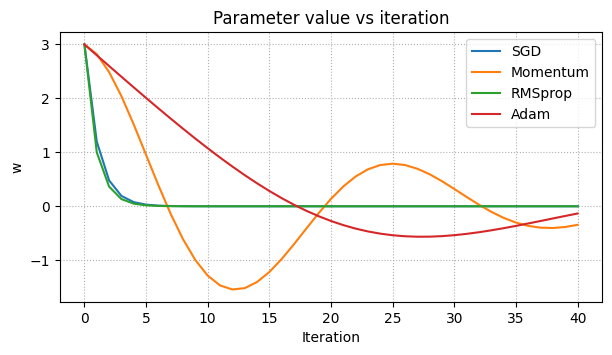

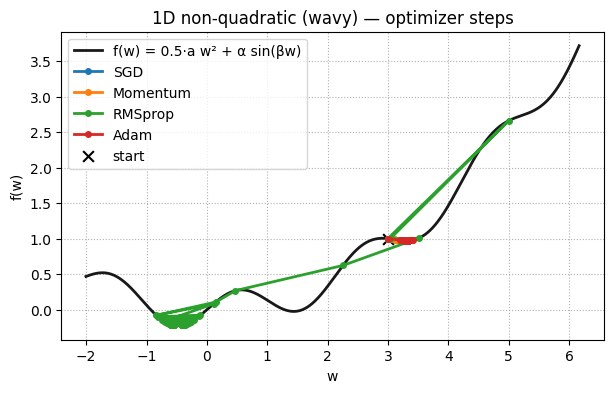

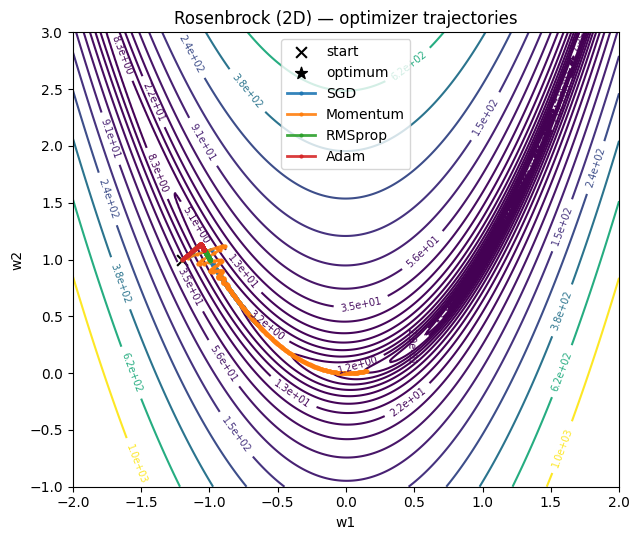

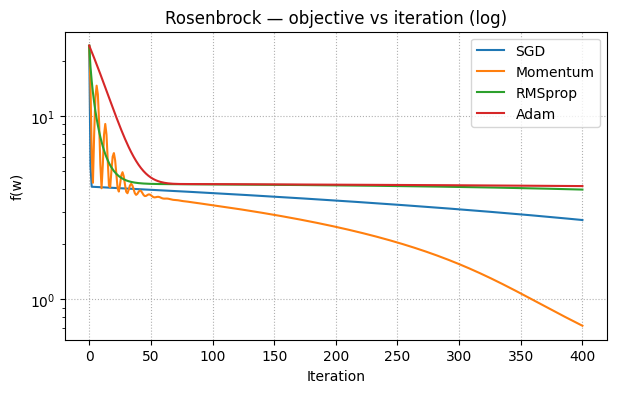

In [3]:
# 1D Quadratic: f(w) = 0.5 * a * w^2 + b * w + c
def make_quadratic_1d(a=5.0, b=0.0, c=0.0):
    def f(w):
        return 0.5 * a * w * w + b * w + c
    def grad(w):
        return a * w + b
    return f, grad, a, b, c

# Optimizer steps (stateful), no torch.optim
def sgd_step(w, g, state, lr=0.05):
    return w - lr * g, state

def momentum_step(w, g, state, lr=0.05, beta=0.9):
    v = state.get('v', torch.zeros_like(w))
    v = beta * v + (1 - beta) * g
    w = w - lr * v
    state['v'] = v
    return w, state

def rmsprop_step(w, g, state, lr=0.05, beta=0.99, eps=1e-8):
    s = state.get('s', torch.zeros_like(w))
    s = beta * s + (1 - beta) * (g * g)
    w = w - lr * g / (torch.sqrt(s) + eps)
    state['s'] = s
    return w, state

def adam_step(w, g, state, lr=0.05, b1=0.9, b2=0.999, eps=1e-8):
    m = state.get('m', torch.zeros_like(w))
    v = state.get('v', torch.zeros_like(w))
    t = state.get('t', 0) + 1
    m = b1 * m + (1 - b1) * g
    v = b2 * v + (1 - b2) * (g * g)
    m_hat = m / (1 - b1**t)
    v_hat = v / (1 - b2**t)
    w = w - lr * m_hat / (torch.sqrt(v_hat) + eps)
    state['m'], state['v'], state['t'] = m, v, t
    return w, state

# Build 1D objective and compare optimizers
f, grad, a, b, c = make_quadratic_1d(a=3.0, b=0.0, c=0.0)
w0 = torch.tensor(3.0)
steps = 40
trajectories = {}
optimizers = {
    'SGD': sgd_step,
    'Momentum': momentum_step,
    'RMSprop': rmsprop_step,
    'Adam': adam_step,
}
colors = { 'SGD': 'C0', 'Momentum': 'C1', 'RMSprop': 'C2', 'Adam': 'C3' }
lrs = { 'SGD': 0.2, 'Momentum': 0.2, 'RMSprop': 0.2, 'Adam': 0.2 }
for name, step_fn in optimizers.items():
    w = w0.clone()
    state = {}
    ws, fs = [float(w.item())], [float(f(w).item())]
    for t in range(steps):
        g = grad(w)
        w, state = step_fn(w, g, state, lr=lrs[name])
        ws.append(float(w.item()))
        fs.append(float(f(w).item()))
    trajectories[name] = {'w': np.array(ws), 'f': np.array(fs)}

# 1) Plot the 1D function and overlay optimizer steps
# Dynamically choose x-range to cover all optimizer positions
ws_all = np.concatenate([d['w'] for d in trajectories.values()])
ws_all = ws_all[np.isfinite(ws_all)]
xmin, xmax = float(ws_all.min()), float(ws_all.max())
span = max(1e-3, xmax - xmin); pad = 0.1 * span
xs = np.linspace(xmin - pad, xmax + pad, 500)
fx = 0.5 * a * xs**2 + b * xs + c
plt.figure(figsize=(7,4))
plt.plot(xs, fx, 'k-', alpha=0.9, lw=2.0, label='f(w)')
for name, d in trajectories.items():
    plt.plot(d['w'], d['f'], 'o-', ms=4, lw=2, label=name, color=colors[name])
plt.scatter([float(w0.item())], [float(f(w0).item())], c='k', marker='x', s=60, label='start')
plt.scatter([0.0], [0.0], c='k', marker='*', s=80, label='optimum')
plt.xlabel('w'); plt.ylabel('f(w)')
plt.title('Optimizer steps along the 1D function')
plt.grid(True, ls=':'); plt.legend()
plt.show()

# 2) f(w) vs iteration (log y)
plt.figure(figsize=(7,4))
for name, d in trajectories.items():
    plt.plot(d['f'] + 1e-12, label=name, color=colors[name])
plt.yscale('log'); plt.xlabel('Iteration'); plt.ylabel('f(w)')
plt.title('Objective vs iteration (log)')
plt.grid(True, ls=':'); plt.legend()
plt.show()

# 3) w vs iteration (position over time)
plt.figure(figsize=(7,3.5))
for name, d in trajectories.items():
    plt.plot(d['w'], label=name, color=colors[name])
plt.xlabel('Iteration'); plt.ylabel('w')
plt.title('Parameter value vs iteration')
plt.grid(True, ls=':'); plt.legend()
plt.show()

# 4) 1D non-quadratic (wavy) — momentum/adaptive can help
def make_wavy_1d(a=0.2, alpha=0.2, beta=3.0):
    def f(w):
        return 0.5 * a * w * w + alpha * torch.sin(beta * w)
    def g(w):
        return a * w + alpha * beta * torch.cos(beta * w)
    return f, g, a, alpha, beta

fw, gw, a_w, alpha_w, beta_w = make_wavy_1d(a=0.2, alpha=0.25, beta=3.0)
w0w = torch.tensor(3.0)
stepsw = 60
trajw = {}
for name, step_fn in optimizers.items():
    w = w0w.clone()
    state = {}
    ws, fs = [float(w.item())], [float(fw(w).item())]
    for t in range(stepsw):
        g = gw(w)
        w, state = step_fn(w, g, state, lr=lrs[name])
        ws.append(float(w.item()))
        fs.append(float(fw(w).item()))
    trajw[name] = {'w': np.array(ws), 'f': np.array(fs)}

# Plot wavy function + steps
ws_all = np.concatenate([d['w'] for d in trajw.values()])
ws_all = ws_all[np.isfinite(ws_all)]
xmin, xmax = float(ws_all.min()), float(ws_all.max()); span = max(1e-3, xmax - xmin); pad = 0.2 * span
xs = np.linspace(xmin - pad, xmax + pad, 600)
fx = 0.5 * a_w * xs**2 + alpha_w * np.sin(beta_w * xs)
plt.figure(figsize=(7,4))
plt.plot(xs, fx, 'k-', alpha=0.9, lw=2.0, label='f(w) = 0.5·a w² + α sin(βw)')
for name, d in trajw.items():
    plt.plot(d['w'], d['f'], 'o-', ms=4, lw=2, label=name, color=colors[name])
plt.scatter([float(w0w.item())], [float(fw(w0w).item())], c='k', marker='x', s=60, label='start')
plt.xlabel('w'); plt.ylabel('f(w)')
plt.title('1D non-quadratic (wavy) — optimizer steps')
plt.grid(True, ls=':'); plt.legend()
plt.show()

# 5) Rosenbrock 2D demo (why Momentum/Adam help)
def make_rosenbrock(a=1.0, b=100.0):
    def f2(w):
        x, y = w[0], w[1]
        return (a - x)**2 + b * (y - x**2)**2
    def g2(w):
        x, y = w[0], w[1]
        dx = -2*(a - x) - 4*b*x*(y - x**2)
        dy =  2*b*(y - x**2)
        return torch.stack([dx, dy])
    return f2, g2

f2, g2 = make_rosenbrock()
w0_2d = torch.tensor([-1.2, 1.0])
steps2 = 400
lrs2 = { 'SGD': 1e-3, 'Momentum': 2e-3, 'RMSprop': 2e-3, 'Adam': 3e-3 }
traj2 = {}
for name, step_fn in optimizers.items():
    w = w0_2d.clone()
    state = {}
    path = [w.numpy().copy()]
    vals = [float(f2(w).item())]
    for t in range(steps2):
        g = g2(w)
        w, state = step_fn(w, g, state, lr=lrs2[name])
        path.append(w.numpy().copy())
        vals.append(float(f2(w).item()))
    traj2[name] = {'w': np.stack(path), 'f': np.array(vals)}

# Contours + trajectories
xs = np.linspace(-2.0, 2.0, 300)
ys = np.linspace(-1.0, 3.0, 300)
XX, YY = np.meshgrid(xs, ys)
ZZ = (1 - XX)**2 + 100.0 * (YY - XX**2)**2
plt.figure(figsize=(6.5,5.5))
cs = plt.contour(XX, YY, ZZ, levels=np.logspace(-2, 3, 25), cmap='viridis')
plt.clabel(cs, inline=True, fontsize=7, fmt='%.1e')
plt.scatter([w0_2d[0].item()], [w0_2d[1].item()], c='k', marker='x', s=60, label='start')
plt.scatter([1.0], [1.0], c='k', marker='*', s=80, label='optimum')
for name, d in traj2.items():
    w = d['w']
    plt.plot(w[:,0], w[:,1], '-o', ms=2, lw=2, alpha=0.9, label=name, color=colors[name])
plt.xlabel('w1'); plt.ylabel('w2')
plt.title('Rosenbrock (2D) — optimizer trajectories')
plt.legend()
plt.tight_layout()
plt.show()

# Objective vs iteration (log)
plt.figure(figsize=(7,4))
for name, d in traj2.items():
    plt.plot(d['f'] + 1e-12, label=name, color=colors[name])
plt.yscale('log'); plt.xlabel('Iteration'); plt.ylabel('f(w)')
plt.title('Rosenbrock — objective vs iteration (log)')
plt.grid(True, ls=':'); plt.legend()
plt.show()


## Overfitting on a Simple Regression
We’ll fit sin(2x) with noise using a small MLP (under-parameterized) and a large MLP (over-parameterized).
We use manual activations and manual optimizer updates (no `torch.optim`).

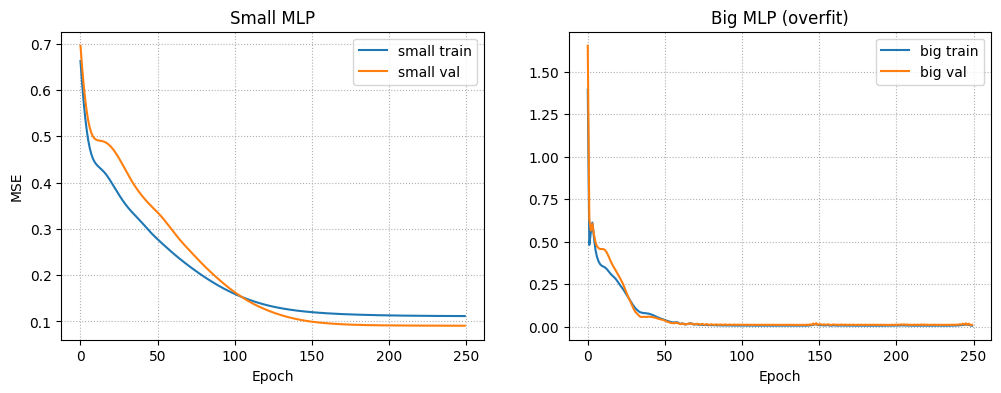

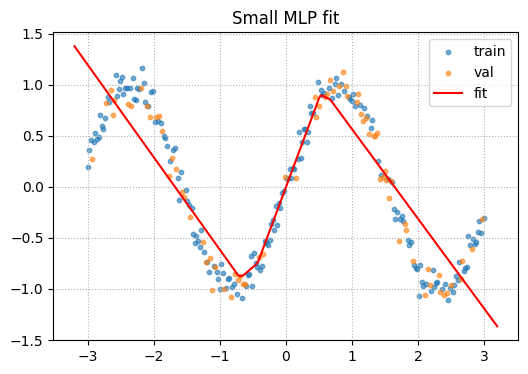

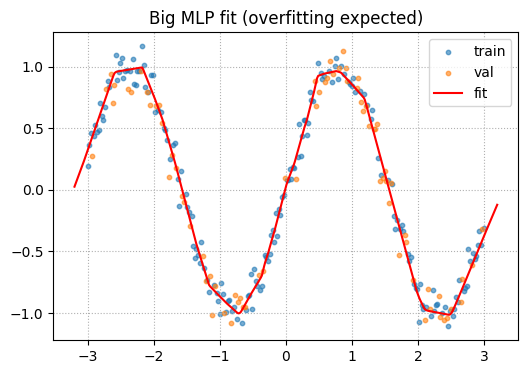

In [4]:
# Data: y = sin(2x) + noise
def make_regression(n=256, noise=0.1):
    x = torch.linspace(-3, 3, n).unsqueeze(1)
    y = torch.sin(2 * x) + noise * torch.randn_like(x)
    idx = torch.randperm(n)
    n_train = int(0.7 * n)
    train_idx, val_idx = idx[:n_train], idx[n_train:]
    return (x[train_idx], y[train_idx]), (x[val_idx], y[val_idx])

(xtr, ytr), (xva, yva) = make_regression(n=256, noise=0.1)
xtr, ytr, xva, yva = xtr.to(device), ytr.to(device), xva.to(device), yva.to(device)
x_plot = torch.linspace(-3.2, 3.2, 400).unsqueeze(1).to(device)

# Custom Linear layer using basic ops and Parameters
class MyLinear(nn.Module):
    def __init__(self, in_f, out_f):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_f, out_f) * math.sqrt(2.0 / (in_f + out_f)))
        self.b = nn.Parameter(torch.zeros(out_f))
    def forward(self, x):
        return x @ self.W + self.b

# Manual Dropout (inverted)
class MyDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
    def forward(self, x):
        if not self.training or self.p == 0.0:
            return x
        mask = (torch.rand_like(x) > self.p).float()
        return mask * x / (1.0 - self.p)

# BatchNorm1d from scratch (forward)
class MyBatchNorm1d(nn.Module):
    def __init__(self, num_features, momentum=0.1, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        self.momentum = momentum
        self.eps = eps
    def forward(self, x):
        # x: (N, F)
        if self.training:
            mean = x.mean(dim=0)
            var = x.var(dim=0, unbiased=False)
            # update running stats (in-place to keep buffers)
            self.running_mean.mul_(1 - self.momentum).add_(self.momentum * mean.detach())
            self.running_var.mul_(1 - self.momentum).add_(self.momentum * var.detach())
            x_hat = (x - mean) / torch.sqrt(var + self.eps)
        else:
            x_hat = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps)
        return self.gamma * x_hat + self.beta

# LayerNorm from scratch (forward)
class MyLayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.eps = eps
    def forward(self, x):
        # x: (N, F), normalize over F
        mean = x.mean(dim=1, keepdim=True)
        var = x.var(dim=1, keepdim=True, unbiased=False)
        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        return self.gamma * x_hat + self.beta

# MLP configurable with our activations and optional dropout/norm
class MLP(nn.Module):
    def __init__(self, dims, activation='relu', dropout_p=0.0, norm=None):
        super().__init__()
        L = []
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropout = MyDropout(dropout_p) if dropout_p > 0 else None
        for i in range(len(dims)-1):
            self.layers.append(MyLinear(dims[i], dims[i+1]))
            if i < len(dims)-2: # hidden
                if norm == 'batch':
                    self.norms.append(MyBatchNorm1d(dims[i+1]))
                elif norm == 'layer':
                    self.norms.append(MyLayerNorm(dims[i+1]))
                else:
                    self.norms.append(nn.Identity())
        self.activation = activation
    def act(self, x):
        if self.activation == 'relu': return relu(x)
        if self.activation == 'sigmoid': return sigmoid(x)
        if self.activation == 'gelu': return gelu(x)
        return x
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers)-1:
                x = self.norms[i](x)
                x = self.act(x)
                if self.dropout is not None:
                    x = self.dropout(x)
        return x

# Manual training step with our optimizers and optional L1/L2
def step_update(params, grads, opt_state, opt_name, lr=1e-2):
    # flatten step dispatch
    if opt_name == 'SGD':
        def fn(p, g, st): return sgd_step(p, g, st, lr=lr)
    elif opt_name == 'Momentum':
        def fn(p, g, st): return momentum_step(p, g, st, lr=lr)
    elif opt_name == 'RMSprop':
        def fn(p, g, st): return rmsprop_step(p, g, st, lr=lr)
    elif opt_name == 'Adam':
        def fn(p, g, st): return adam_step(p, g, st, lr=lr)
    else:
        raise ValueError('Unknown optimizer')
    # apply param-wise
    for i, (p, g) in enumerate(zip(params, grads)):
        key = f'p{i}'
        st = opt_state.get(key, {})
        new_p, new_st = fn(p, g, st)
        p.data.copy_(new_p.data)
        opt_state[key] = new_st
    return opt_state

def l1_l2_penalty(params, l1=0.0, l2=0.0):
    l1_term = torch.tensor(0., device=device)
    l2_term = torch.tensor(0., device=device)
    for p in params:
        l1_term = l1_term + p.abs().sum()
        l2_term = l2_term + (p**2).sum()
    return l1 * l1_term + l2 * l2_term

def params_of(model):
    return [m for m in model.parameters() if m.requires_grad]

def train_regression(model, xtr, ytr, xva, yva, epochs=200, lr=1e-2, opt='Adam', l1=0.0, l2=0.0):
    model = model.to(device)
    hist = {'train': [], 'val': [], 'l1norm': [], 'l2norm': []}
    opt_state = {}
    for ep in range(epochs):
        model.train()
        ypred = model(xtr)
        loss = F.mse_loss(ypred, ytr) + l1_l2_penalty(params_of(model), l1=l1, l2=l2)
        for p in model.parameters():
            if p.grad is not None: p.grad.zero_()
        loss.backward()
        grads = [p.grad for p in params_of(model)]
        opt_state = step_update(params_of(model), grads, opt_state, opt, lr=lr)
        # eval
        model.eval()
        with torch.no_grad():
            tr = F.mse_loss(model(xtr), ytr).item()
            va = F.mse_loss(model(xva), yva).item()
            l1n = sum(p.abs().sum().item() for p in params_of(model))
            l2n = math.sqrt(sum((p**2).sum().item() for p in params_of(model)))
        hist['train'].append(tr)
        hist['val'].append(va)
        hist['l1norm'].append(l1n)
        hist['l2norm'].append(l2n)
    return hist

small = MLP([1, 16, 1], activation='relu')
big = MLP([1, 512, 512, 1], activation='relu')

h_small = train_regression(small, xtr, ytr, xva, yva, epochs=250, lr=5e-3, opt='Adam')
h_big = train_regression(big, xtr, ytr, xva, yva, epochs=250, lr=5e-3, opt='Adam')

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(h_small['train'], label='small train')
axs[0].plot(h_small['val'], label='small val')
axs[0].legend(); axs[0].set_title('Small MLP')
axs[0].set_xlabel('Epoch'); axs[0].set_ylabel('MSE')
axs[1].plot(h_big['train'], label='big train')
axs[1].plot(h_big['val'], label='big val')
axs[1].legend(); axs[1].set_title('Big MLP (overfit)')
axs[1].set_xlabel('Epoch')
for ax in axs: ax.grid(True, ls=':')
plt.show()

# Plot fits
def plot_fit(model, title):
    model.eval()
    with torch.no_grad():
        yhat = model(x_plot).cpu()
    plt.figure(figsize=(6,4))
    plt.scatter(xtr.cpu(), ytr.cpu(), s=10, alpha=0.6, label='train')
    plt.scatter(xva.cpu(), yva.cpu(), s=10, alpha=0.6, label='val')
    plt.plot(x_plot.cpu(), yhat, 'r', label='fit')
    plt.title(title); plt.legend(); plt.grid(True, ls=':')
    plt.show()

plot_fit(small, 'Small MLP fit')
plot_fit(big, 'Big MLP fit (overfitting expected)')


## L1 vs L2 Regularization
We add explicit L1/L2 penalties and track parameter norms over epochs to see how they constrain model capacity differently.

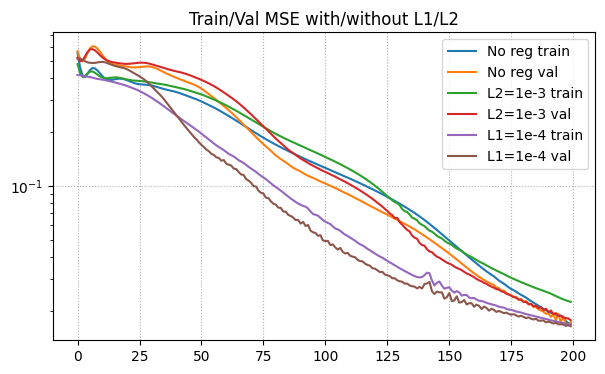

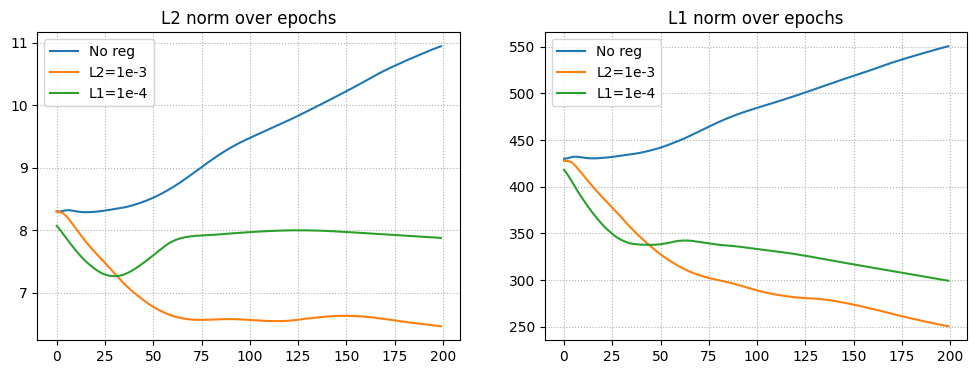

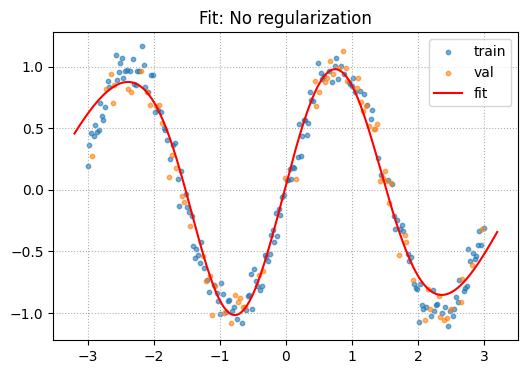

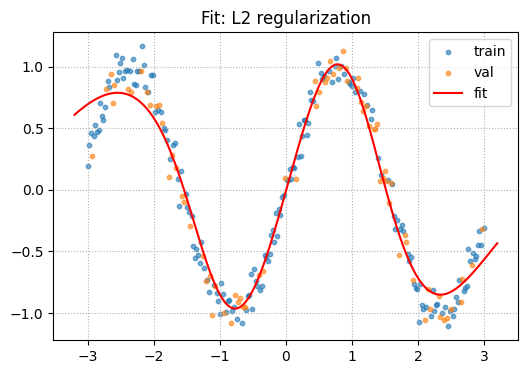

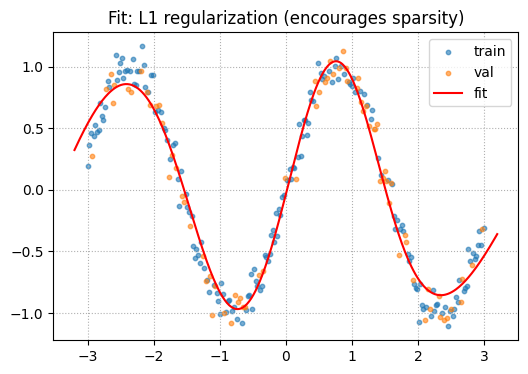

In [5]:
def run_with_reg(l1, l2, label):
    model = MLP([1, 64, 64, 1], activation='gelu')
    h = train_regression(model, xtr, ytr, xva, yva, epochs=200, lr=3e-3, opt='Adam', l1=l1, l2=l2)
    return h, model, label

h0, m0, l0 = run_with_reg(0.0, 0.0, 'No reg')
hL2, mL2, lL2 = run_with_reg(0.0, 1e-3, 'L2=1e-3')
hL1, mL1, lL1 = run_with_reg(1e-4, 0.0, 'L1=1e-4')

plt.figure(figsize=(7,4))
plt.plot(np.array(h0['train']) + 1e-12, label=f'{l0} train')
plt.plot(np.array(h0['val']) + 1e-12, label=f'{l0} val')
plt.plot(np.array(hL2['train']) + 1e-12, label=f'{lL2} train')
plt.plot(np.array(hL2['val']) + 1e-12, label=f'{lL2} val')
plt.plot(np.array(hL1['train']) + 1e-12, label=f'{lL1} train')
plt.plot(np.array(hL1['val']) + 1e-12, label=f'{lL1} val')
plt.yscale('log'); plt.legend(); plt.grid(True, ls=':')
plt.title('Train/Val MSE with/without L1/L2')
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(h0['l2norm'], label=l0); plt.plot(hL2['l2norm'], label=lL2); plt.plot(hL1['l2norm'], label=lL1);
plt.title('L2 norm over epochs'); plt.grid(True, ls=':'); plt.legend()
plt.subplot(1,2,2); plt.plot(h0['l1norm'], label=l0); plt.plot(hL2['l1norm'], label=lL2); plt.plot(hL1['l1norm'], label=lL1);
plt.title('L1 norm over epochs'); plt.grid(True, ls=':'); plt.legend()
plt.show()

plot_fit(m0, 'Fit: No regularization')
plot_fit(mL2, 'Fit: L2 regularization')
plot_fit(mL1, 'Fit: L1 regularization (encourages sparsity)')


## Dropout
We apply our manual inverted Dropout between layers and compare generalization. Dropout is active in training and disabled in evaluation automatically.

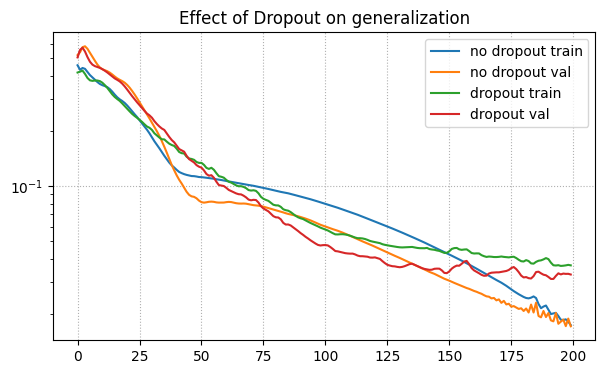

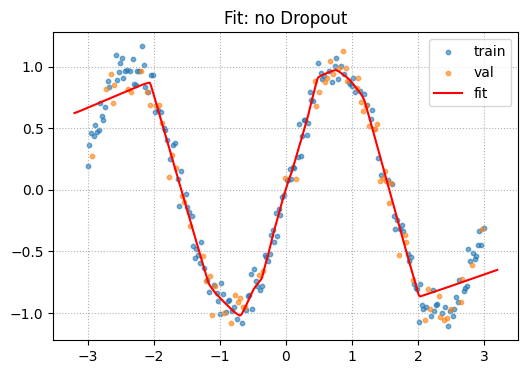

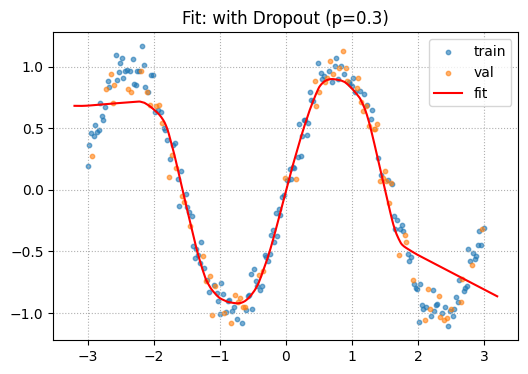

In [6]:
model_no_do = MLP([1, 128, 128, 1], activation='relu', dropout_p=0.0)
model_do = MLP([1, 128, 128, 1], activation='relu', dropout_p=0.3)
h_no = train_regression(model_no_do, xtr, ytr, xva, yva, epochs=200, lr=3e-3, opt='Adam')
h_do = train_regression(model_do, xtr, ytr, xva, yva, epochs=200, lr=3e-3, opt='Adam')
plt.figure(figsize=(7,4))
plt.plot(np.array(h_no['train']) + 1e-12, label='no dropout train')
plt.plot(np.array(h_no['val']) + 1e-12, label='no dropout val')
plt.plot(np.array(h_do['train']) + 1e-12, label='dropout train')
plt.plot(np.array(h_do['val']) + 1e-12, label='dropout val')
plt.yscale('log'); plt.legend(); plt.grid(True, ls=':')
plt.title('Effect of Dropout on generalization')
plt.show()
plot_fit(model_no_do, 'Fit: no Dropout')
plot_fit(model_do, 'Fit: with Dropout (p=0.3)')


## BatchNorm vs LayerNorm
We use our custom BatchNorm1d and LayerNorm forward passes to show stabilized activations and training.
We also visualize histograms before and after normalization for a batch.

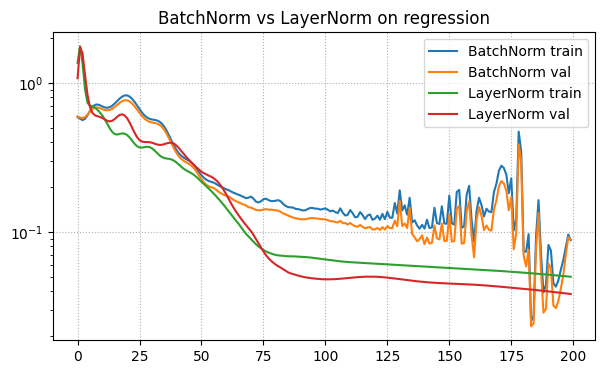

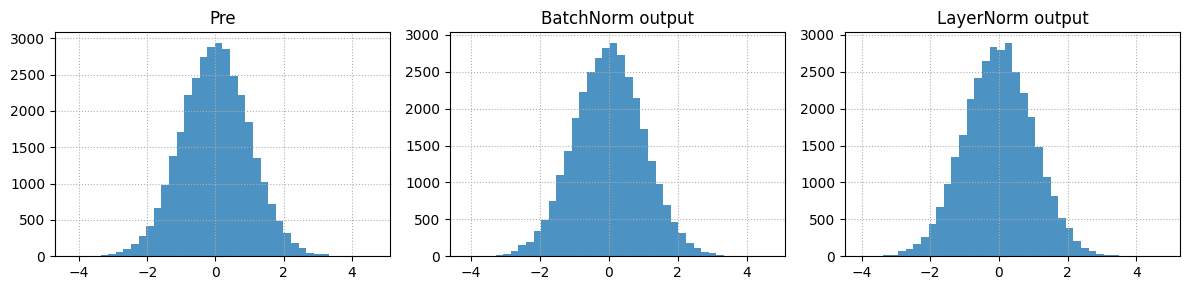

In [7]:
bn_model = MLP([1, 128, 128, 1], activation='gelu', norm='batch')
ln_model = MLP([1, 128, 128, 1], activation='gelu', norm='layer')
h_bn = train_regression(bn_model, xtr, ytr, xva, yva, epochs=200, lr=3e-3, opt='Adam')
h_ln = train_regression(ln_model, xtr, ytr, xva, yva, epochs=200, lr=3e-3, opt='Adam')
plt.figure(figsize=(7,4))
plt.plot(np.array(h_bn['train']) + 1e-12, label='BatchNorm train')
plt.plot(np.array(h_bn['val']) + 1e-12, label='BatchNorm val')
plt.plot(np.array(h_ln['train']) + 1e-12, label='LayerNorm train')
plt.plot(np.array(h_ln['val']) + 1e-12, label='LayerNorm val')
plt.yscale('log'); plt.legend(); plt.grid(True, ls=':')
plt.title('BatchNorm vs LayerNorm on regression')
plt.show()

# Histogram visualization on a fresh batch
with torch.no_grad():
    x_batch = torch.randn(256, 128)
    bn = MyBatchNorm1d(128).train()
    ln = MyLayerNorm(128).train()
    pre = x_batch
    post_bn = bn(pre)
    post_ln = ln(pre)

fig, axs = plt.subplots(1, 3, figsize=(12,3))
axs[0].hist(pre.flatten().numpy(), bins=40, alpha=0.8); axs[0].set_title('Pre')
axs[1].hist(post_bn.flatten().numpy(), bins=40, alpha=0.8); axs[1].set_title('BatchNorm output')
axs[2].hist(post_ln.flatten().numpy(), bins=40, alpha=0.8); axs[2].set_title('LayerNorm output')
for ax in axs: ax.grid(True, ls=':')
plt.tight_layout(); plt.show()


## Simple Data Augmentations (No torchvision)
We illustrate augmentations on a sample image using basic tensor ops: flips, 90° rotations, random crops, and Gaussian noise.
You can adapt these into your Dataset `__getitem__` for training.

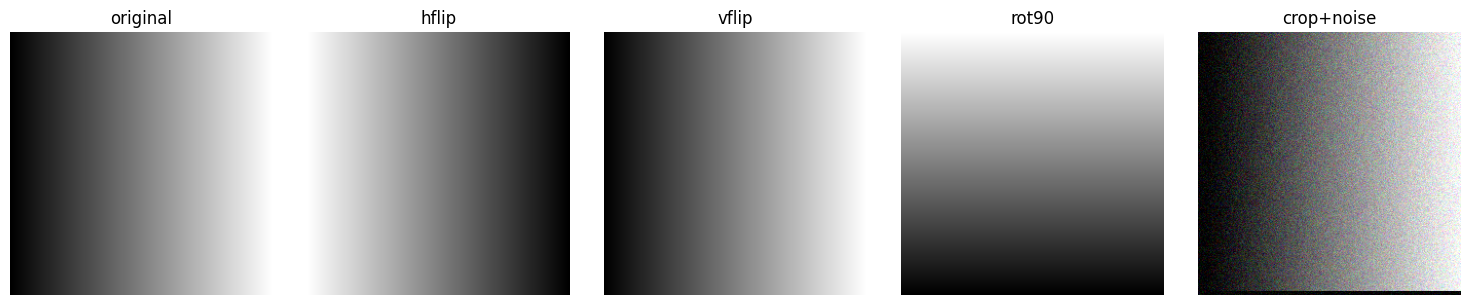

In [8]:
def to_tensor(img):
    t = torch.from_numpy(np.array(img)).float() / 255.0
    if t.ndim == 2: t = t.unsqueeze(-1)
    # HWC -> CHW
    return t.permute(2,0,1)

def to_image(t):
    t = (t.clamp(0,1) * 255.0).byte()
    # CHW -> HWC
    t = t.permute(1,2,0).cpu().numpy()
    return Image.fromarray(t)

def hflip(x):
    return torch.flip(x, dims=[2])
def vflip(x):
    return torch.flip(x, dims=[1])
def rot90(x, k=1):
    k = k % 4
    return torch.rot90(x, k, dims=[1,2])
def random_crop(x, size=128, padding=8):
    C,H,W = x.shape
    p = padding
    xp = torch.zeros((C, H+2*p, W+2*p), dtype=x.dtype)
    xp[:, p:p+H, p:p+W] = x
    yy = random.randint(0, H+2*p - size)
    xx = random.randint(0, W+2*p - size)
    return xp[:, yy:yy+size, xx:xx+size]
def add_noise(x, sigma=0.05):
    return x + sigma * torch.randn_like(x)

# Load a sample image from the repo (Lab04/relu.png)
img_path = Path('Lab04/relu.png')
if img_path.exists():
    img = Image.open(img_path).convert('RGB')
else:
    # fallback: synthetic pattern
    arr = np.tile(np.linspace(0,255,256).astype(np.uint8), (256,1))
    img = Image.fromarray(np.stack([arr, np.flipud(arr), arr], axis=-1))
x = to_tensor(img)

samples = []
samples.append(('original', x))
samples.append(('hflip', hflip(x)))
samples.append(('vflip', vflip(x)))
samples.append(('rot90', rot90(x, k=1)))
samples.append(('crop+noise', add_noise(random_crop(x, size=min(x.shape[1], x.shape[2]), padding=16), 0.07)))

fig, axs = plt.subplots(1, len(samples), figsize=(3*len(samples), 3))
for ax, (name, xt) in zip(axs, samples):
    ax.imshow(to_image(xt))
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout(); plt.show()

